In [1]:
import os
import re
import json
import errno
import pandas as pd

from shutil import rmtree

from tqdm import tqdm
from glob import iglob
from ast import literal_eval
from os.path import join as pjoin

In [2]:
SRC_DIR = "/home/kimsubin/workspace/"
DATA_DIR = "/home/kimsubin/data/" 

CUB_DATA_DIR = pjoin(DATA_DIR, "CUB_200_2011")

CUB_IMAGE_DIR = pjoin(CUB_DATA_DIR, "images")
CUB_ATTR_DIR = pjoin(CUB_DATA_DIR, "attributes")
CUB_PART_DIR = pjoin(CUB_DATA_DIR, "parts")

In [3]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

def read_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def write_json(save_path, json_obj):
    with open(save_path, 'w', encoding='utf-8') as make_file:
        json.dump(json_obj, make_file, indent="\t")
    return

In [5]:
train_annot = read_json(pjoin(CUB_DATA_DIR, "annotations", "train.json"))
test_annot = read_json(pjoin(CUB_DATA_DIR, "annotations", "test.json"))

In [6]:
train_annot

[{'image_path': '193.Bewick_Wren/Bewick_Wren_0010_185142.jpg',
  'image_id': '11347',
  'split': True,
  'parts': [{'part_id': '1.0',
    'part_name': 'back',
    'x': 221.0,
    'y': 153.0,
    'visible': True},
   {'part_id': '2.0',
    'part_name': 'beak',
    'x': 298.0,
    'y': 112.0,
    'visible': True},
   {'part_id': '3.0',
    'part_name': 'belly',
    'x': 253.0,
    'y': 205.0,
    'visible': True},
   {'part_id': '4.0',
    'part_name': 'breast',
    'x': 273.0,
    'y': 171.0,
    'visible': True},
   {'part_id': '5.0',
    'part_name': 'crown',
    'x': 253.0,
    'y': 117.0,
    'visible': True},
   {'part_id': '6.0',
    'part_name': 'forehead',
    'x': 277.0,
    'y': 113.0,
    'visible': True},
   {'part_id': '7.0',
    'part_name': 'left eye',
    'x': 0.0,
    'y': 0.0,
    'visible': False},
   {'part_id': '8.0',
    'part_name': 'left leg',
    'x': 264.0,
    'y': 232.0,
    'visible': True},
   {'part_id': '9.0',
    'part_name': 'left wing',
    'x': 0.0,
 

In [7]:
import torch
from torch import nn
from dataclasses import dataclass
from typing import Any, Optional, Tuple, Union

from transformers.utils import ModelOutput
from transformers.models.instructblip import (
        InstructBlipPreTrainedModel,
        InstructBlipConfig,
        InstructBlipProcessor,
        InstructBlipVisionModel,
        InstructBlipQFormerModel
    )
    
@dataclass
# Copied from transformers.models.blip_2.modeling_blip_2.Blip2ForConditionalGenerationModelOutput with Blip2->InstructBlip
class InstructBlipForImageRetrievalModelOutput(ModelOutput):
    """
    Class defining the outputs of [`InstructBlipForImageRetrievalModelOutput`].

    Args:
        loss (`torch.FloatTensor`, *optional*, returned when `labels` is provided, `torch.FloatTensor` of shape `(1,)`):
            Language modeling loss from the language model.
        logits (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.vocab_size)`):
            Prediction scores of the language modeling head of the language model.
        vision_outputs (`BaseModelOutputWithPooling`):
            Outputs of the vision encoder.
        qformer_outputs (`BaseModelOutputWithPoolingAndCrossAttentions`):
            Outputs of the Q-Former (Querying Transformer).
        language_model_outputs (`CausalLMOutputWithPast` or `Seq2SeqLMOutput`):
            Outputs of the language model.
    """

    loss: Optional[Tuple[torch.FloatTensor]] = None
    logits: Optional[Tuple[torch.FloatTensor]] = None
    vision_outputs: Optional[torch.FloatTensor] = None
    qformer_outputs: Optional[Tuple[torch.FloatTensor]] = None

    def to_tuple(self) -> Tuple[Any]:
        return tuple(
            self[k]
            if k not in ["vision_outputs", "qformer_outputs"]
            else getattr(self, k).to_tuple()
            for k in self.keys()
        )


class InstructBlipForImageRetrieval(InstructBlipPreTrainedModel):
    config_class = InstructBlipConfig
    main_input_name = "pixel_values"

    def __init__(self, config: InstructBlipConfig):
        super().__init__(config)

        self.vision_model = InstructBlipVisionModel(config.vision_config)
        self.query_tokens = nn.Parameter(torch.zeros(1, config.num_query_tokens, config.qformer_config.hidden_size))
        self.qformer = InstructBlipQFormerModel(config.qformer_config)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        qformer_input_ids: torch.FloatTensor,
        qformer_attention_mask: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, InstructBlipForImageRetrievalModelOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # step 1: forward the images through the vision encoder,
        # to get image embeddings of shape (batch_size, seq_len, hidden_size)
        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        image_embeds = vision_outputs[0]

        # step 2: forward the query tokens through the QFormer, using the image embeddings for cross-attention
        image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long, device=image_embeds.device)

        # difference with BLIP-2 here: we also feed the instruction prompt to the Q-Former
        query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
        query_attention_mask = torch.ones(query_tokens.size()[:-1], dtype=torch.long, device=image_embeds.device)
        if qformer_attention_mask is None:
            qformer_attention_mask = torch.ones_like(qformer_input_ids)
        qformer_attention_mask = torch.cat([query_attention_mask, qformer_attention_mask], dim=1)
        query_outputs = self.qformer(
            input_ids=qformer_input_ids,
            attention_mask=qformer_attention_mask,
            query_embeds=query_tokens,
            encoder_hidden_states=image_embeds,
            encoder_attention_mask=image_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        query_output = query_outputs[0][:, : query_tokens.size(1), :]

        return InstructBlipForImageRetrievalModelOutput(
            vision_outputs=vision_outputs,
            qformer_outputs=query_outputs,
        )
    

/home/kimsubin/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import InstructBlipProcessor
import torch
from PIL import Image

model_name = "Salesforce/instructblip-flan-t5-xxl"
processor = InstructBlipProcessor.from_pretrained(model_name)

qformer_tokenizer/tokenizer_config.json: 100%|██████████| 343/343 [00:00<00:00, 2.21MB/s]
qformer_tokenizer/vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 577kB/s]
qformer_tokenizer/tokenizer.json: 100%|██████████| 712k/712k [00:00<00:00, 884kB/s]
qformer_tokenizer/added_tokens.json: 100%|██████████| 21.0/21.0 [00:00<00:00, 112kB/s]
preprocessor_config.json: 100%|██████████| 439/439 [00:00<00:00, 2.34MB/s]
tokenizer_config.json: 100%|██████████| 2.42k/2.42k [00:00<00:00, 13.2MB/s]
spiece.model: 100%|██████████| 792k/792k [00:00<00:00, 15.7MB/s]
tokenizer.json: 100%|██████████| 2.42M/2.42M [00:01<00:00, 2.35MB/s]
special_tokens_map.json: 100%|██████████| 2.20k/2.20k [00:00<00:00, 12.0MB/s]


In [10]:
model = InstructBlipForImageRetrieval.from_pretrained(model_name)

config.json: 100%|██████████| 6.85k/6.85k [00:00<00:00, 21.0MB/s]
pytorch_model.bin.index.json: 100%|██████████| 135k/135k [00:00<00:00, 342kB/s]
pytorch_model-00001-of-00005.bin: 100%|██████████| 9.99G/9.99G [09:01<00:00, 18.5MB/s]
pytorch_model-00002-of-00005.bin: 100%|██████████| 9.97G/9.97G [08:19<00:00, 20.0MB/s]
pytorch_model-00003-of-00005.bin: 100%|██████████| 9.87G/9.87G [10:19<00:00, 15.9MB/s]
pytorch_model-00004-of-00005.bin: 100%|██████████| 10.0G/10.0G [08:06<00:00, 20.5MB/s]
pytorch_model-00005-of-00005.bin: 100%|██████████| 9.42G/9.42G [08:05<00:00, 19.4MB/s]
Loading checkpoint shards: 100%|██████████| 5/5 [00:41<00:00,  8.24s/it]


In [11]:
mkdir_p(pjoin(SRC_DIR, "models"))
mkdir_p(pjoin(SRC_DIR, "processors"))

model.save_pretrained(pjoin(SRC_DIR, "models"))
processor.save_pretrained(pjoin(SRC_DIR, "processors"))

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

InstructBlipForImageRetrieval(
  (vision_model): InstructBlipVisionModel(
    (embeddings): InstructBlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): InstructBlipEncoder(
      (layers): ModuleList(
        (0-38): 39 x InstructBlipEncoderLayer(
          (self_attn): InstructBlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): InstructBlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
     

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

In [20]:
transform = Compose([
    Resize((224, 224))
])

In [21]:
def extract_feature(
    model, 
    processor, 
    image: Image=None, 
    attribute: str=None, 
    image_path: str=None, 
    device: str='cpu'
    ):
    if image is None:
        image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, text=attribute, return_tensors="pt").to(device)
    return model(pixel_values=inputs['pixel_values'],
                qformer_input_ids=inputs['qformer_input_ids'],
                qformer_attention_mask=inputs['qformer_attention_mask'],
                output_attentions=True)


In [24]:
sample = test_annot[0]
sample

{'image_path': '001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg',
 'image_id': '1',
 'split': False,
 'parts': [{'part_id': '1.0',
   'part_name': 'back',
   'x': 0.0,
   'y': 0.0,
   'visible': False},
  {'part_id': '2.0',
   'part_name': 'beak',
   'x': 312.0,
   'y': 182.0,
   'visible': True},
  {'part_id': '3.0',
   'part_name': 'belly',
   'x': 0.0,
   'y': 0.0,
   'visible': False},
  {'part_id': '4.0',
   'part_name': 'breast',
   'x': 0.0,
   'y': 0.0,
   'visible': False},
  {'part_id': '5.0',
   'part_name': 'crown',
   'x': 186.0,
   'y': 45.0,
   'visible': True},
  {'part_id': '6.0',
   'part_name': 'forehead',
   'x': 247.0,
   'y': 79.0,
   'visible': True},
  {'part_id': '7.0',
   'part_name': 'left eye',
   'x': 0.0,
   'y': 0.0,
   'visible': False},
  {'part_id': '8.0',
   'part_name': 'left leg',
   'x': 0.0,
   'y': 0.0,
   'visible': False},
  {'part_id': '9.0',
   'part_name': 'left wing',
   'x': 0.0,
   'y': 0.0,
   'visible': False},
  {'part_id

In [26]:
image = Image.open(pjoin(CUB_IMAGE_DIR, sample['image_path'])).convert("RGB")
image = transform(image)

feature = extract_feature(model, processor=processor, 
                image=image,
                attribute=sample['parts'][0]['part_name'],
                device=device)

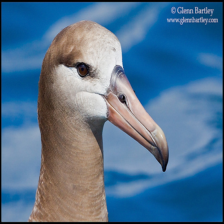

In [27]:
image

In [28]:
attn_map = feature['qformer_outputs']['attentions']

In [18]:
len(attn_map), attn_map[-1].size()

(12, torch.Size([1, 12, 35, 35]))

In [19]:
# Average the attention weights across all heads.
attn_map = torch.stack(attn_map).squeeze(1).cpu()
attn_map = torch.mean(attn_map, dim=1)

In [20]:
attn_map.size()

torch.Size([12, 35, 35])

In [21]:
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(attn_map.size(1))
aug_attn_map = attn_map + residual_att
aug_attn_map = aug_attn_map / aug_attn_map.sum(dim=-1).unsqueeze(-1)

In [22]:
aug_attn_map.size()

torch.Size([12, 35, 35])

In [23]:
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_attn_map.size())
joint_attentions[0] = aug_attn_map[0]

for n in range(1, aug_attn_map.size(0)):
    joint_attentions[n] = torch.matmul(aug_attn_map[n], joint_attentions[n-1])

In [24]:
joint_attentions.size()

torch.Size([12, 35, 35])

In [25]:
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_attn_map.size(-1)))
left_size= v[0, :].size(-1) // grid_size
mask = v[0, :].reshape(grid_size, left_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
result = (mask * image).astype("uint8")

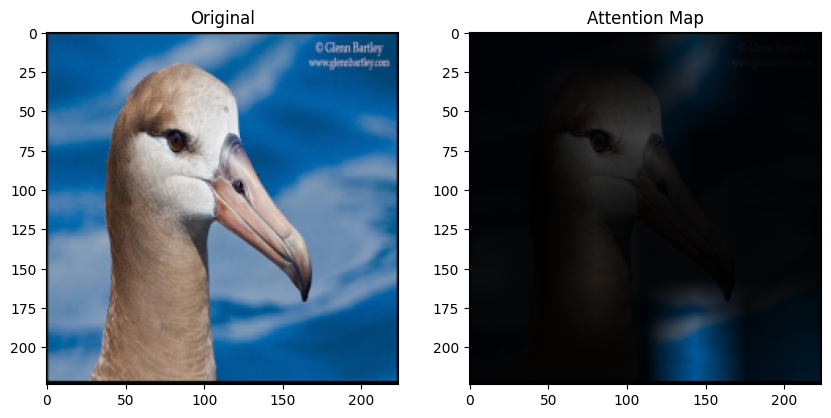

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(result)

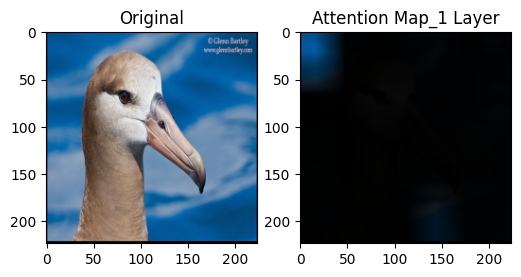

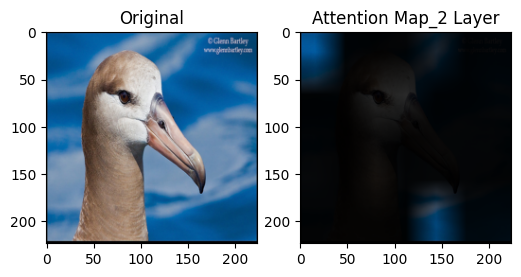

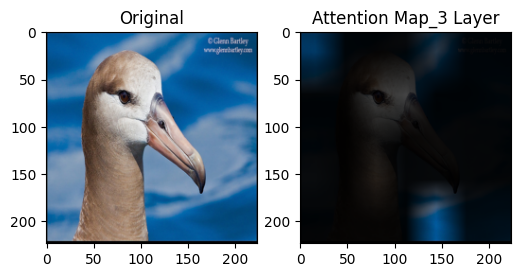

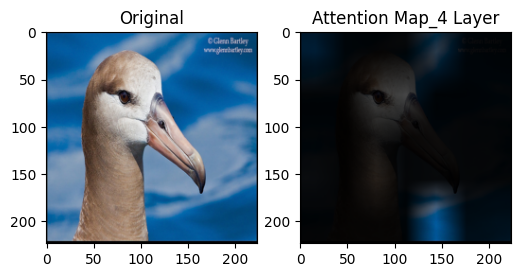

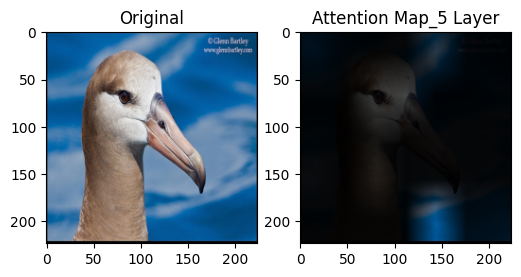

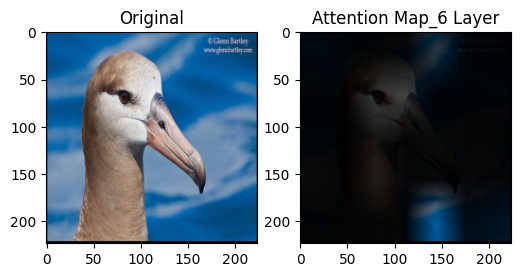

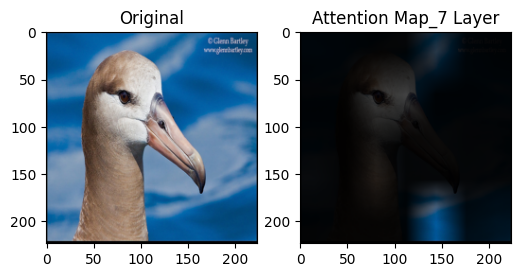

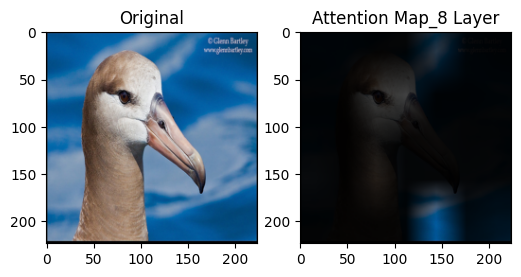

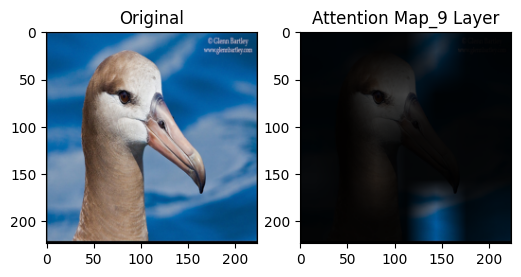

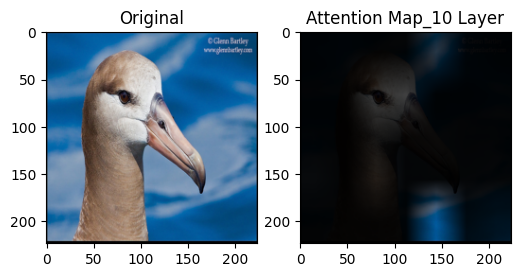

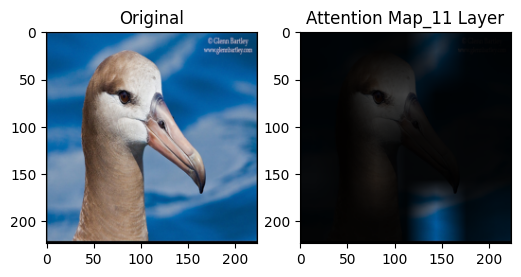

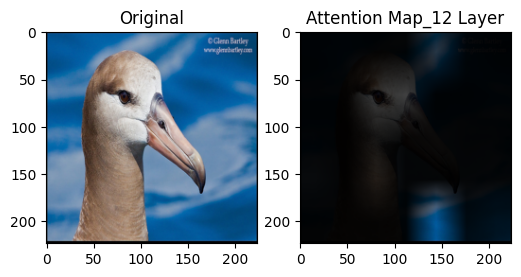

In [27]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    left_size= v[0, :].size(-1) // grid_size
    mask = v[0, :].reshape(grid_size, left_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 6))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(image)
    _ = ax2.imshow(result)

In [28]:
import math

def get_divisor(n):
    divisors = []
    for i in range(1, int(n**(1/2)) + 1):
        if (n % i == 0):
            divisors.append(i) 
            if ( (i**2) != n) : 
                divisors.append(n // i)
    divisors.sort()
    return divisors

def get_grid(map_size):
    min_diff = map_size
    x, y = 1, map_size
    for n in get_divisor(map_size):
        diff = abs(n - map_size // n)
        if diff < min_diff:
            min_diff = diff
            x, y = n, map_size // n
    return x, y

def visualize(image, attn_map, is_joint_attn=False):
    attn_map = torch.stack(attn_map).squeeze(1).cpu()
    attn_map = torch.mean(attn_map, dim=1)

    residual_att = torch.eye(attn_map.size(1))
    aug_attn_map = attn_map + residual_att
    aug_attn_map = aug_attn_map / aug_attn_map.sum(dim=-1).unsqueeze(-1)

    joint_attentions = torch.zeros(aug_attn_map.size())
    joint_attentions[0] = aug_attn_map[0]

    for n in range(1, aug_attn_map.size(0)):
        joint_attentions[n] = torch.matmul(aug_attn_map[n], joint_attentions[n-1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_x, grid_y = get_grid(aug_attn_map.size(-1))
    mask = v[0, :].reshape(grid_x, grid_y).detach().numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(result)

    if is_joint_attn:
        for i, v in enumerate(joint_attentions):
            mask = v[0, :].reshape(grid_x, grid_y).detach().numpy()
            mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
            result = (mask * image).astype("uint8")

            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
            ax1.set_title('Original')
            ax2.set_title('Attention Map_%d Layer' % (i+1))
            _ = ax1.imshow(image)
            _ = ax2.imshow(result)

In [29]:
image = Image.open(pjoin(CUB_IMAGE_DIR, sample['image_path'])).convert("RGB")
image = transform(image)

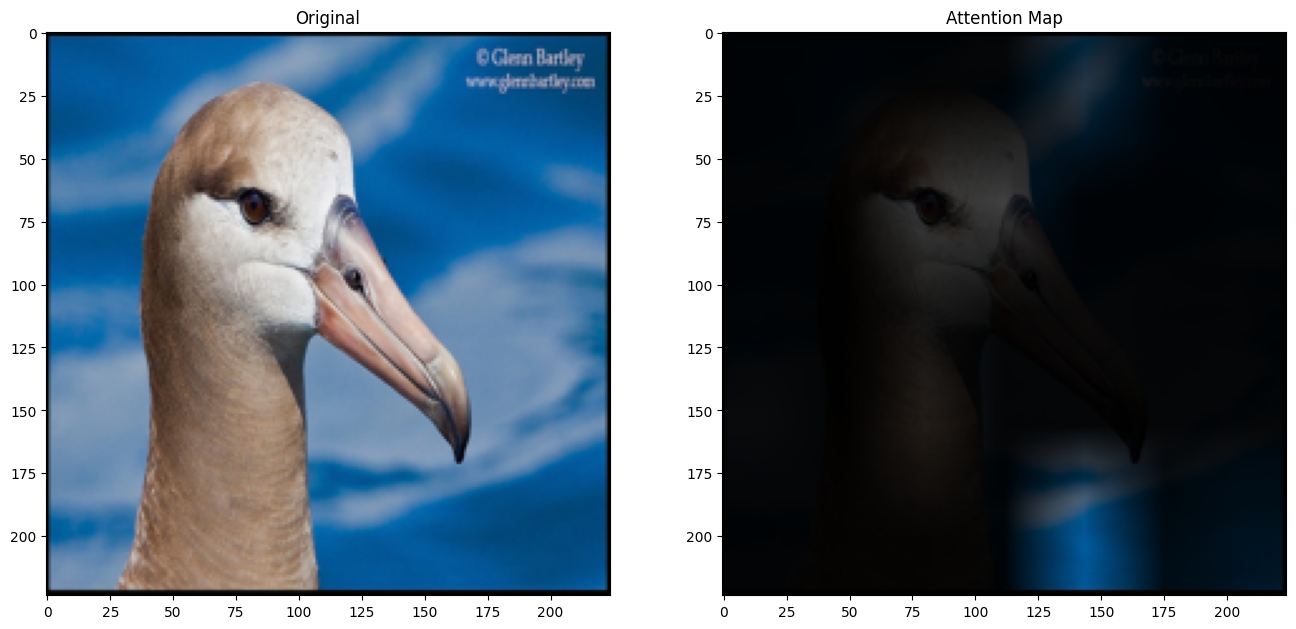

In [30]:
attribute = 'beak'
feature = extract_feature(model, processor=processor, 
                image=image,
                attribute=attribute,
                device=device)
                
visualize(image, feature['qformer_outputs']['attentions'], is_joint_attn=False)

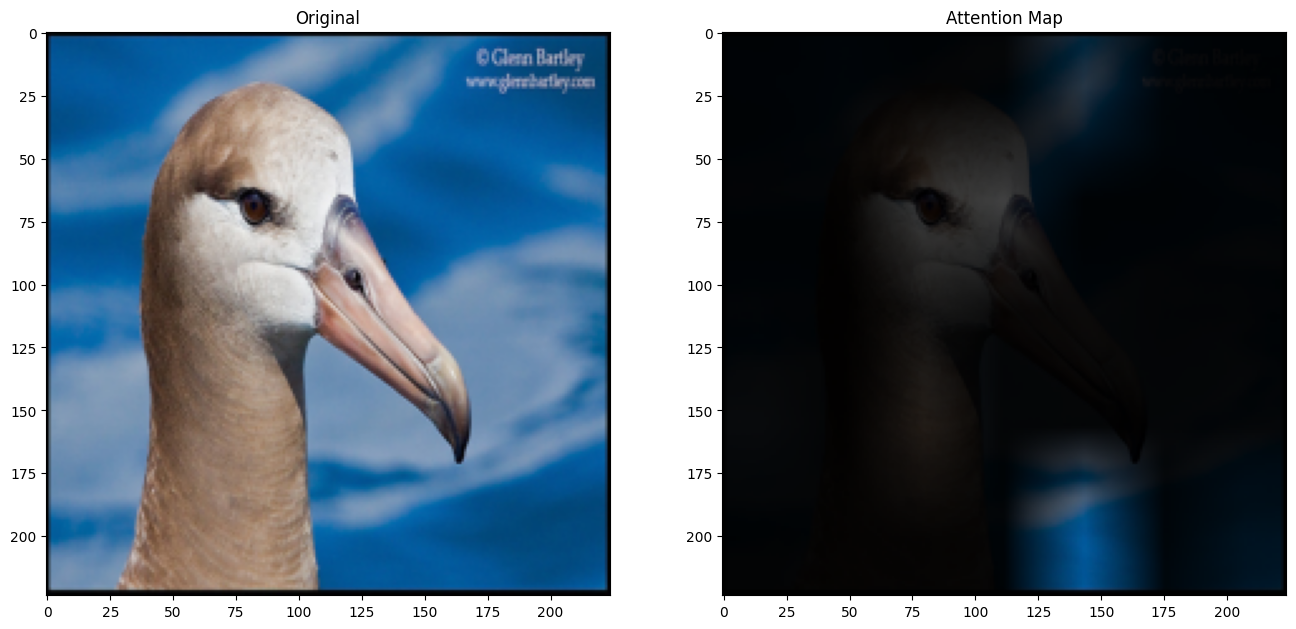

In [31]:
attribute = 'eyes'
feature = extract_feature(model, processor=processor, 
                image=image,
                attribute=attribute,
                device=device)
                
visualize(image, feature['qformer_outputs']['attentions'], is_joint_attn=False)

Q-former output size: torch.Size([1, 12, 42, 42])


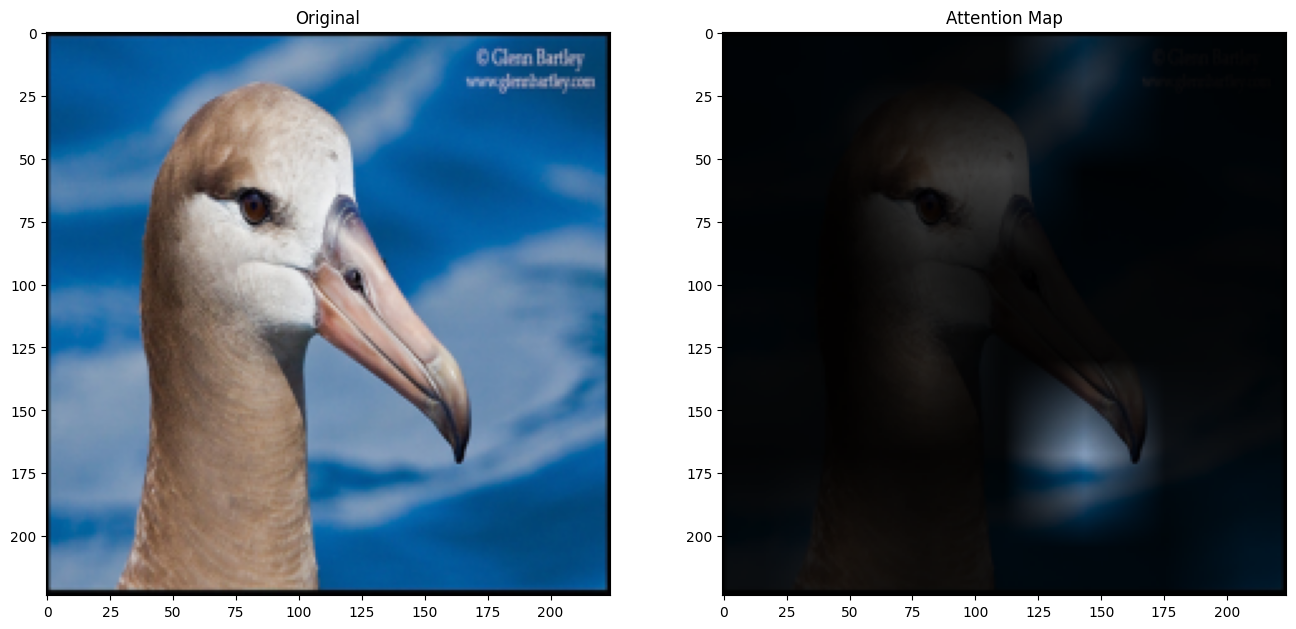

In [32]:
attribute = 'Where is the beak of a bird?'
feature = extract_feature(model, processor=processor, 
                image=image,
                attribute=attribute,
                device=device)

print("Q-former output size:", feature['qformer_outputs']['attentions'][-1].size())   
visualize(image, feature['qformer_outputs']['attentions'], is_joint_attn=False)

In [35]:
attribute = 'Look at the beak of a bire'
feature = extract_feature(model, processor=processor, 
                image=image,
                attribute=attribute,
                device=device)

print("Q-former output size:", feature['qformer_outputs']['attentions'][-1].size())   

Q-former output size: torch.Size([1, 12, 42, 42])


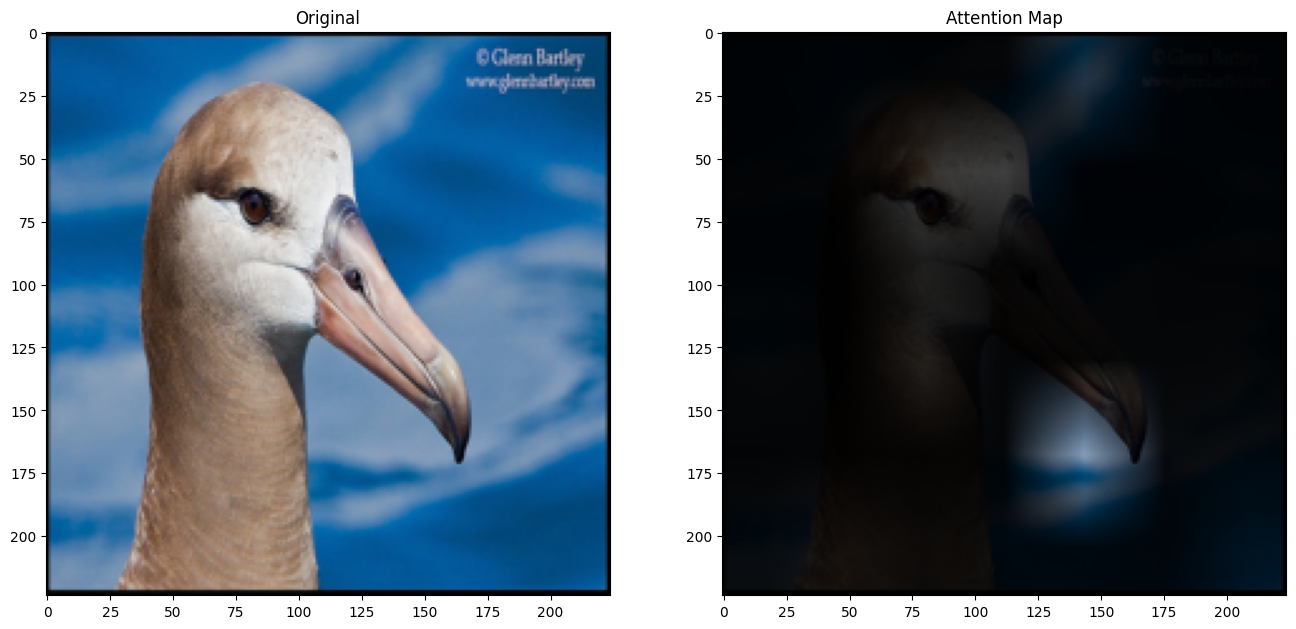

In [36]:
visualize(image, feature['qformer_outputs']['attentions'], is_joint_attn=False)